In [4]:
from itertools import groupby
from json import load
import pandas as pd
import scanpy as sc
import numpy as np
import sys
import tests.loadScanpy as loadScanpy
import classifyClusters as classify
import os
from scipy.sparse import csr_matrix
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import diffxpy.api as de
from diffexpr.diffexpr.py_deseq import py_DESeq2
import pandas as pd 
import numpy as np


####################################################################################################
# Global Settings 
####################################################################################################
np.set_printoptions(threshold=sys.maxsize)
pd.options.display.max_columns = sys.maxsize
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)

inputData = "./dataSaveOriginal/rawDataset5000.h5ad" # ./dataSaveOriginal/rawDataset5000.h5ad
results_file = './output/savedData.h5ad'
outputDirectory = "./outputPDFs/"

# Arguments Settings

sysArgs = sys.argv

showPlots = False
if "-showPlots" in sysArgs:
    showPlots = True
else:
    showPlots = False

arg = ""
for word in sysArgs:
    if word != "main.py" and word != "-showPlots":
        arg = arg + word + " "
        # if "-" not in word:
        #     OUTPUT_DIR = outputDirectory+word+"/"
        #     CHECK_FOLDER = os.path.isdir(OUTPUT_DIR)
        #     if not CHECK_FOLDER:
        #         os.makedirs(OUTPUT_DIR)
        #     outputDirectory = OUTPUT_DIR
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'    

####################################################################################################
# Import Data 
####################################################################################################
print(bcolors.FAIL + "Importing Data..." + bcolors.ENDC)
if "-loadGenomics" in sysArgs:
    adata = loadScanpy.readData()
    print(adata)
else:
    adata = sc.read(inputData)
adata.var_names_make_unique()

geneMarkers = pd.read_csv('./dataSaveOriginal/cellTypeMarkers.csv')
geneNames = geneMarkers["gene"].tolist()

genesHSA21 = pd.read_csv("./dataSaveOriginal/HSA21genes.csv")
genesHSA21List = []

for gene in genesHSA21["hgnc_symbol"].tolist():
    if type(gene) == str:
        genesHSA21List.append(gene)

# ####################################################################################################
# # Pre-Processing
# ####################################################################################################
adataCON_DS2U =  adata[adata.obs["sample"] == "CON_DS2U"]
adataCON_H9 =  adata[adata.obs["sample"] == "CON_H9"]
adataCON_IMR =  adata[adata.obs["sample"] == "CON_IMR"]
adataCON_ihtc =  adata[adata.obs["sample"] == "CON_ihtc"]
adataDS_2DS3 =  adata[adata.obs["sample"] == "DS_2DS3"]
adataDS_DS1 =  adata[adata.obs["sample"] == "DS_DS1"]
adataDS_DSP =  adata[adata.obs["sample"] == "DS_DSP"]
adata = adataCON_DS2U.concatenate(adataCON_H9)
adata = adata.concatenate(adataCON_IMR)
adata = adata.concatenate(adataDS_2DS3)
adata = adata.concatenate(adataDS_DSP)
adata.raw = adata
# adata.var['mt'] = adata.var_names.str.startswith('MT-')
# riboURL = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt"
# riboGenes = pd.read_table(riboURL, skiprows=2, header = None)
# adata.var['ribo'] = adata.var_names.isin(riboGenes[0].values)
# sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', "ribo"], percent_top=None, log1p=False, inplace=True)
# sc.pp.normalize_total(adata, target_sum=10000)
# sc.pp.log1p(adata)
# sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
# sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
# sc.pp.scale(adata, max_value=10)
# sc.tl.pca(adata, svd_solver='arpack')
# sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40) # n_neighbors=15 is default
# sc.tl.umap(adata)
# sc.tl.leiden(adata, resolution=0.5)
# sc.external.pp.bbknn(adata, batch_key='sample')

# ####################################################################################################
# # Differential Expression Using DESeq2
# ####################################################################################################
print(bcolors.FAIL + "Performing Differential Expression using DESeq2..." + bcolors.ENDC)
def getColSample(string):
    subset =  adata[adata.obs["sample"] == string]
    returnArray = [sum(x) for x in zip(*subset.X)]
    print(string)
    print(returnArray[0])
    return returnArray[0].toarray()[0]

rows = adata.var["features"].values

# CON_DS2U CON_H9 CON_IMR CON_ihtc DS_2DS3 DS_DS1 DS_DSP

df = pd.DataFrame(rows, columns=['id'])
df["N_1"] = getColSample("CON_DS2U")
df["N_2"] = getColSample("CON_H9")
df["N_3"] = getColSample("CON_IMR")
df["S_1"] = getColSample("DS_2DS3")
df["S_2"] = getColSample("DS_DSP")

print(df.head(10))

df.N_1 = df.N_1.astype(int)
df.N_2 = df.N_2.astype(int)
df.N_3 = df.N_3.astype(int)
df.S_1 = df.S_1.astype(int)
df.S_2 = df.S_2.astype(int)
print(df.head(50))

print("Setting Sample Dataframe...")
sample_df = pd.DataFrame({'samplename': df.columns}) \
        .query('samplename != "id"')\
        .assign(sample = lambda d: d.samplename.str.extract('([NS])_', expand=False)) \
        .assign(replicate = lambda d: d.samplename.str.extract('_([123])', expand=False)) 
sample_df.index = sample_df.samplename

sample_df

Importing Data...


/opt/homebrew/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/opt/homebrew/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/opt/homebrew/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic

Performing Differential Expression using DESeq2...
CON_DS2U
  (0, 3)	3.0
  (0, 6)	16.0
  (0, 8)	1.0
  (0, 14)	105.0
  (0, 16)	100.0
  (0, 17)	17.0
  (0, 18)	6.0
  (0, 19)	41.0
  (0, 20)	36.0
  (0, 21)	7.0
  (0, 23)	9.0
  (0, 24)	311.0
  (0, 25)	44.0
  (0, 28)	51.0
  (0, 29)	2163.0
  (0, 30)	106.0
  (0, 31)	2.0
  (0, 32)	163.0
  (0, 36)	265.0
  (0, 37)	44.0
  (0, 38)	2.0
  (0, 41)	5.0
  (0, 43)	1.0
  (0, 44)	256.0
  (0, 45)	203.0
  :	:
  (0, 36515)	4.0
  (0, 36516)	158.0
  (0, 36517)	11.0
  (0, 36518)	90.0
  (0, 36519)	318.0
  (0, 36556)	1.0
  (0, 36559)	17494.0
  (0, 36560)	9770.0
  (0, 36561)	50837.0
  (0, 36562)	42095.0
  (0, 36563)	237.0
  (0, 36564)	51031.0
  (0, 36565)	50323.0
  (0, 36566)	12079.0
  (0, 36567)	474.0
  (0, 36568)	28654.0
  (0, 36569)	5258.0
  (0, 36570)	481.0
  (0, 36571)	30418.0
  (0, 36575)	181.0
  (0, 36576)	3.0
  (0, 36580)	4.0
  (0, 36581)	82.0
  (0, 36599)	89.0
  (0, 36600)	1.0
CON_H9
  (0, 3)	4.0
  (0, 6)	21.0
  (0, 14)	123.0
  (0, 16)	81.0
  (0, 17)	17.0
  

,samplename,sample,replicate
samplename,,,
N_1,N_1,N,1
N_2,N_2,N,2
N_3,N_3,N,3
S_1,S_1,S,1
S_2,S_2,S,2


In [5]:
df

,id,N_1,N_2,N_3,S_1,S_2
0,MIR1302-2HG,0,0,1,0,0
1,FAM138A,0,0,0,0,0
2,OR4F5,0,0,0,0,0
3,AL627309.1,3,4,6,8,3
4,AL627309.3,0,0,0,0,0
...,...,...,...,...,...,...
36596,AC141272.1,0,0,0,0,0
36597,AC023491.2,0,0,0,0,0
36598,AC007325.1,0,0,0,0,0
36599,AC007325.4,89,43,63,56,62


In [6]:

print("Running DESeq2...")
dds = py_DESeq2(count_matrix = df,
               design_matrix = sample_df,
               design_formula = '~ replicate + sample',
               gene_column = 'id') # <- telling DESeq2 this should be the gene ID column
    
dds.run_deseq() 
dds.get_deseq_result(contrast = ['sample','S','N'])
res = dds.deseq_result 

res = res.sort_values(['log2FoldChange'], ascending = [True])

res

geneList = res["id"].tolist()[0:50]
print(geneList)

# geneList = ["LOXL3", "M1AP"]

plotDF = pd.DataFrame(columns=["CON", "DS"]) # index = geneList
i = 0
for resultGene in geneList:
    rowResult = df.loc[df['id'] == resultGene]
    averageCON = float((rowResult["N_1"]+rowResult["N_2"]+rowResult["N_3"])/3)
    averageDS = float((rowResult["S_1"]+rowResult["S_2"])/2)
    sumTotal = averageCON + averageDS
    normalCON = float(averageCON/sumTotal)
    normalDS = float(averageDS/sumTotal)
    plotDF.loc[resultGene] = [averageCON, averageDS]
    i +=1


Running DESeq2...








INFO:DESeq2:Using contrast: ['sample', 'S', 'N']


['CHCHD2', 'ZNF558', 'COL22A1', 'LINC02028', 'OPRK1', 'AL353622.1', 'FAM242E', 'FAM135B', 'ANKRD18B', 'AC024022.1', 'PSTPIP1', 'LINC01210', 'AC007368.1', 'LINC02826', 'RSPO1', 'AC090348.1', 'DPP6', 'LHX5-AS1', 'AL122035.2', 'PM20D1', 'CEBPA-DT', 'LYNX1', 'AC011416.3', 'TCEAL5', 'TTC22', 'SKOR2', 'AC063960.2', 'CFAP73', 'MSR1', 'AL354863.1', 'HMCN1', 'VSX1', 'RSPO2', 'TERT', 'FREM2-AS1', 'AC092335.1', 'AC025508.1', 'LINC02058', 'BAALC-AS2', 'AC090809.1', 'TMEM236', 'LINC01954', 'IRX1', 'COL24A1', 'TMEM132D', 'ZCCHC24', 'AL161851.2', 'IKBKE', 'AC006974.2', 'LINC01121']


In [7]:
res

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,id
CHCHD2,1372.562229,-11.725420,1.504833,-7.791839,6.604108e-15,4.766846e-11,CHCHD2
ZNF558,39.923183,-8.398152,1.682090,-4.992690,5.954418e-07,4.775443e-04,ZNF558
COL22A1,17.700327,-7.814851,4.787175,-1.632456,1.025835e-01,NaN,COL22A1
LINC02028,81.803829,-7.432582,4.344113,-1.710955,8.708943e-02,9.999587e-01,LINC02028
OPRK1,10.510254,-6.427551,2.142334,-3.000256,2.697529e-03,NaN,OPRK1
...,...,...,...,...,...,...,...
AC136616.3,0.000000,NaN,NaN,NaN,NaN,NaN,AC136616.3
AC136616.2,0.000000,NaN,NaN,NaN,NaN,NaN,AC136616.2
AC141272.1,0.000000,NaN,NaN,NaN,NaN,NaN,AC141272.1
AC023491.2,0.000000,NaN,NaN,NaN,NaN,NaN,AC023491.2


In [8]:
genesHSA21data = pd.DataFrame(columns=["baseMean", "log2FoldChange", "lfcSE", "stat", "pvalue", "padj", "id"]) 

for index, row in genesHSA21data.iterrows():
    rowGene = res.loc[res['id'] == row["id"]]
    print(rowGene)
    genesHSA21data.loc[1] = rowGene


genesHSA21data

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,id


In [9]:
plotDF

,CON,DS
CHCHD2,2343.333333,1.0
ZNF558,68.666667,0.0
COL22A1,29.666667,0.0
LINC02028,130.333333,0.0
OPRK1,18.666667,0.0
AL353622.1,32.666667,0.5
FAM242E,8.000000,0.0
FAM135B,19.666667,0.5
ANKRD18B,10.000000,0.0
AC024022.1,10.000000,0.0


... storing 'orig.ident' as categorical
... storing 'group' as categorical
... storing 'sample' as categorical
... storing 'SCT_snn_res.0.8' as categorical
... storing 'clust_orig' as categorical
... storing 'clust_orig_lab' as categorical
... storing 'clust_recl' as categorical
... storing 'cluster_type' as categorical


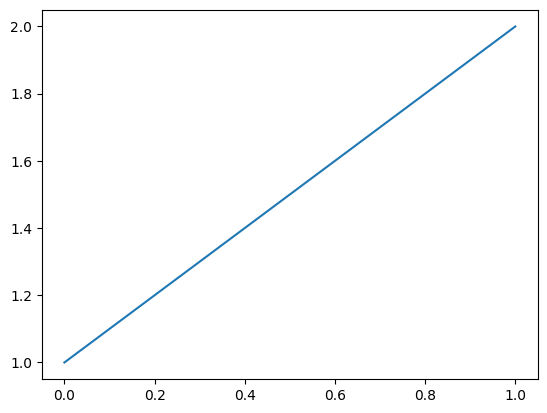

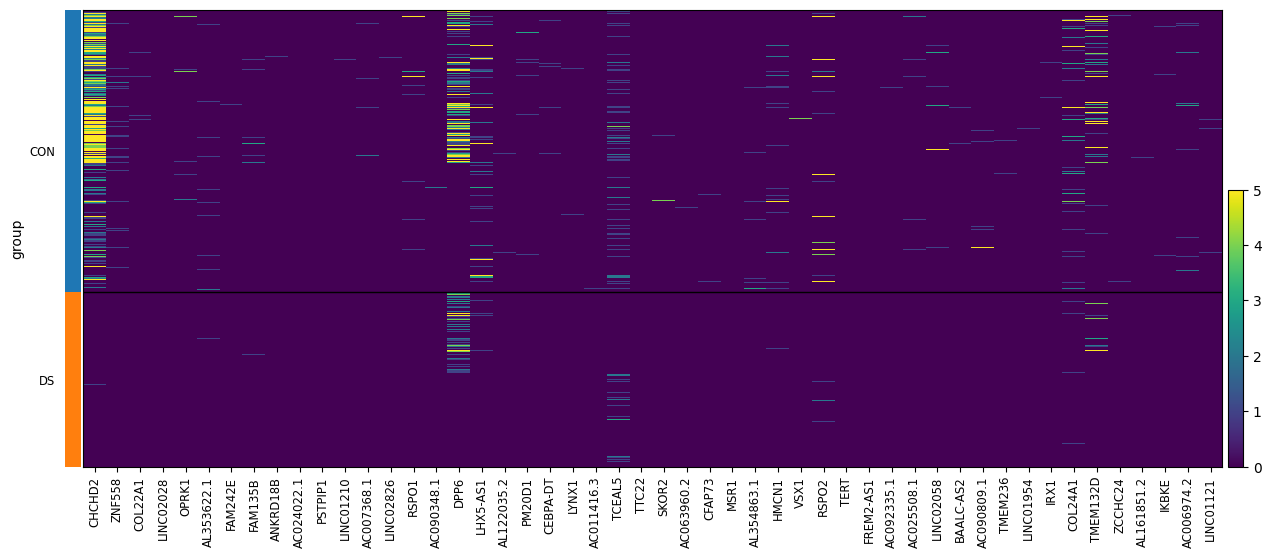

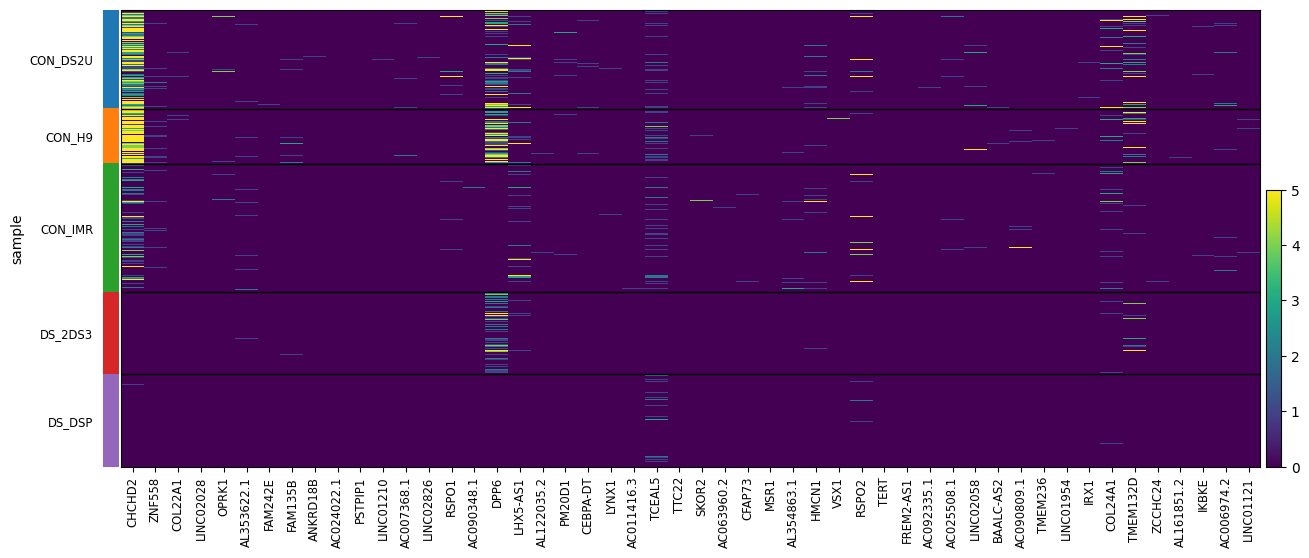

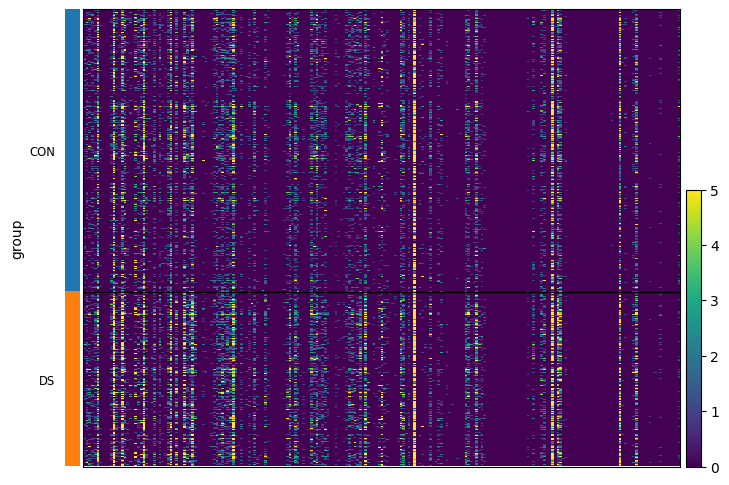

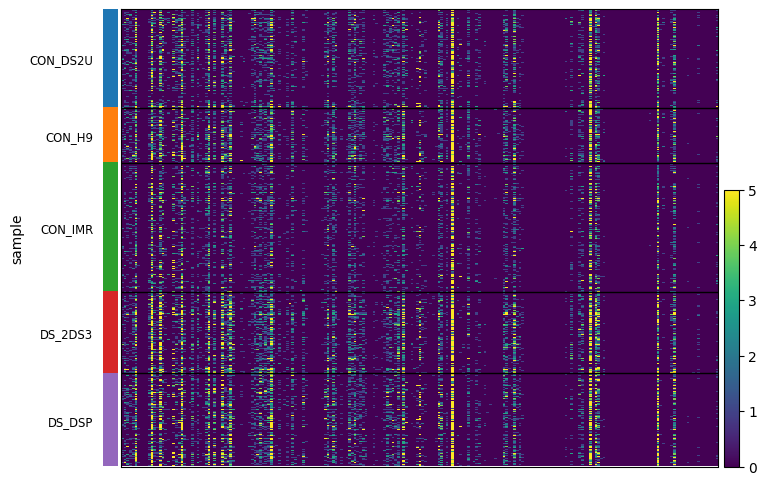

In [10]:
presMarkers = ["MITF", "EMX2", "ZNF558", "KLF3", "ZNF589", "ZNF337", "ZNF16", "HMGA1", "ZIC2", "MECOM", "ESR2", "ZNF536", "RFXANK", "DLX1", "DLX2", "RORB", "OLIG2", "ZBTB20", "CREB3L2", "NPAS2", "ZNF491", "PBX3", "AFF2", "ZNF425", "ZHX3", "PKNOX1", "ARNT", "FOXN3", "GATAD2B", "ASH1L"]

with PdfPages(outputDirectory+'Differential Expression DESeq2 Test.pdf') as pdf:
    dummyPlot = plt.plot([1, 2])
    figureNum = plt.gcf().number

    # sns.heatmap(plotDF, annot=True, cmap=sns.blend_palette(["black", "green"], as_cmap=True))
    # plt.show()

    genesHSA21List.remove('H2BS1')
    genesHSA21List.remove('CFAP298-TCP10L')
    genesHSA21List.remove('GET1-SH3BGR')
    genesHSA21List.remove('SLX9')


    sc.pl.heatmap(adata, geneList, groupby="group", vmax=5, show=False)
    sc.pl.heatmap(adata, geneList, groupby="sample", vmax=5, show=False)
    sc.pl.heatmap(adata, genesHSA21List, groupby="group", vmax=5, show=False)
    sc.pl.heatmap(adata, genesHSA21List, groupby="sample", vmax=5, show=False)

    for fig in range(figureNum+1,  plt.gcf().number+1):
        pdf.savefig(figure=fig, bbox_inches='tight')